# Cleaning Titanic train and test datasets
    
### This notebook will do the following to prepare the raw datasets for some simple machine learning models:

    - Impute or drop Missing Values 
    - Generate some basic characteristics from raw fields
    - Create Dummy variables from categorical fields
    - Export the cleaned datasets for use in subsequent ML notebooks

#### Import essential Dataframe and Visualization libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

#### Read in both train and test CSVs

In [4]:
train = pd.read_csv('./train.csv')

In [5]:
test = pd.read_csv('./test.csv')

#### Check format of dataset

In [6]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


#### Check descriptive statistics of all variables

In [7]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hosono, Mr. Masabumi",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### Check for Missing Values in all variables for both train and test datasets

In [8]:
pd.concat(
    [pd.DataFrame(train.isnull().sum(),columns=['train MV']),
     pd.DataFrame(test.isnull().sum(),columns=['test MV'])],axis=1)

,train MV,test MV
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


## Characteristic Generation

#### Creating a field to capture the passengers "Title"

    - One of the first things we notice is that the Name field is not usable as is but the passengers title (ie. Mr, Mrs., etc...) may be predictive as to who survives. 
    - In order to capture this information, we will split the Name field and take the string preceding the period.
    - Further, we will strip any whitespace to ensure the titles are consistent 

In [9]:
def Title(name):
    return name.split(',')[1].split('.')[0].strip()

#### Check value counts 

In [10]:
train['Name'].apply(Title).value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Don               1
Sir               1
Ms                1
Capt              1
Lady              1
Mme               1
the Countess      1
Jonkheer          1
Name: Name, dtype: int64

#### In the value counts above, we notice a few things:
    - one records has a value of "Ms" while a number of records have the value "Miss". These are synonymous so we will rename "Ms" to "Miss'
    - there are a number of records with very low counts (<6). Not all of these may be present in the testing data so we will group all these values together and assign them the label of "Other"

In [11]:
def CleanTitle(title):
    titles =['Mr','Miss','Mrs','Master','Dr','Rev']
    if title == 'Ms':
        return 'Miss'
    elif title not in titles:
        return 'Other'
    else:
        return title

#### Check that the CleanTitle function defined above is generating desired output

In [12]:
train['Name'].apply(Title).apply(CleanTitle).value_counts()

Mr        517
Miss      183
Mrs       125
Master     40
Other      13
Dr          7
Rev         6
Name: Name, dtype: int64

#### Apply Title and CleanTitle Functions to train and test dataset to create new field "Title"

In [13]:
train['Title'] = train['Name'].apply(Title).apply(CleanTitle)
test['Title'] = test['Name'].apply(Title).apply(CleanTitle)

### Create field to capture information about passenger's Cabin

    - After looking at the MV counts and descriptive stats of the field 'Cabin' we notice a few things:
        - The field has very high cardinality (most repeated value only has 4 counts)
        - The field is missing for most of the passengers
        - The first letter of the cabins have much lower cardinality (Might indicate the zone of the boat the passenger was staying in). This may be predicitve of whether or not a person survives

#### Define a function to return the first letter of "Cabin" if it is not missing. Else return "Missing"

In [14]:
def CabinLetter(cabin):
    try:
        return cabin[0]
    except:
        return 'Missing'

#### Check value counts after applying CabinLetter function

In [15]:
train['Cabin'].apply(CabinLetter).value_counts()

Missing    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin, dtype: int64

#### In the value counts above, we notive that a few cabin letters have very few counts. We may not see these values in the test dataset and including them as their own values may lead to overfitting. Thus we will define a cleaning function to assign CabinLetter values with very low counts to the value "Other"

In [16]:
def CleanCabinLetter(letter):
    letters = ['A','B','C','D','E','F','Missing']
    if letter in letters:
        return letter
    else:
        return 'Other'

#### Check the output of CabinLetter and CleanCabinLetter functions to ensure they are working correctly

In [17]:
train['Cabin'].apply(CabinLetter).apply(CleanCabinLetter).value_counts()

Missing    687
C           59
B           47
D           33
E           32
A           15
F           13
Other        5
Name: Cabin, dtype: int64

#### Apply CabinLetter and CleanCabinLetter functions to the train and test datasets to create the field "CabinLetter"

In [18]:
train['CabinLetter'] = train['Cabin'].apply(CabinLetter).apply(CleanCabinLetter)
test['CabinLetter'] = test['Cabin'].apply(CabinLetter).apply(CleanCabinLetter)

## Create a field to count how many other passengers share the same ticket numer

### Looking at the descriptive statistics we notice a few things about the "Ticket" field
    - The field as very high cardinality
    - There are a number of passengers that share the same ticket number as other passengers
    - We beilieve this may indicate families traveling together 
    - The maximum for repeated tickets is 7
    - It is possible that the number of times a passengers ticket number shows up in the dataset provides some information on the passengers probability of survival

#### Create a dataset ds_tickets for both the train and test datasets that contains the value counts of each unique ticket number
#### Then merge this dataset with the original train and test datasets on "Ticket" so that each passenger has a count of the number of times his/her ticket shows up in the dataset

In [19]:
ds_tickets = train['Ticket'].value_counts().reset_index().rename(columns={'Ticket': 'TicketCount'})
train = train.merge(ds_tickets, how='left', left_on='Ticket', right_on='index').drop('index',axis=1)

In [20]:
ds_tickets = test['Ticket'].value_counts().reset_index().rename(columns={'Ticket': 'TicketCount'})
test = test.merge(ds_tickets, how='left', left_on='Ticket', right_on='index').drop('index',axis=1) 

#### Check the head of the training dataset to confirm that all Charactertics have been generated and appended to the dataset
    - Title, CabinLetter, TicketCount

In [21]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinLetter,TicketCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,Missing,1


#### We can now drop the Name, Ticket, and Cabin columns since we have generated the charactersitics we want from them

In [22]:
train.drop(['Name','Ticket','Cabin'], axis=1, inplace = True)
test.drop(['Name','Ticket','Cabin'], axis=1, inplace = True)

## Missing Value Imputation

From the Missing Value inspection from above, we can see the following:

    1.) Age has a large number of Missing Values:
        - Age is a missing value so there is no good way to keep the missing values on their own
        - There are too many records missing Age to simply drop them from the training data. Also, we see that the testing dataset also has missing ages so we must find a way to predict survival for these records. 
        - One way to approach this is to estimate the ages for these records in such a way that they will not have high influence on the model fitting.
        
    2.) 2 records are missing the Embarked field in the training data but none are missing it in the testing data. 
        - Because we do not need to provide an estimate for records missing the Embarked field and the number of records missing the field is very small, we can simply drop these records from the training dataset
    3.) 1 record is missing the field "Fare" in the testing dataset. 
    
        - Because we need to estimate the probability of survival for this observation, we will have to impute/estimate the value of Fare for this individual

### Estimating Age for missing values

#### We will first look at the correlation between the predictors in the training dataset to determine which variables have the highest correlation with Age. We can then use the variables correlated with age to estimate values for records missing Age. 

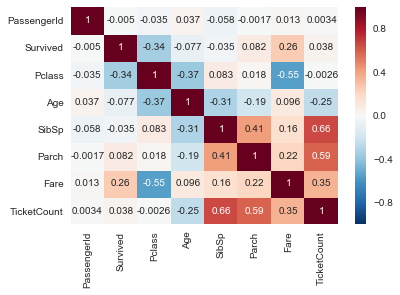

In [23]:
sns.heatmap(train.corr(), annot=True)

#### We see that Pclass has the highest correlation with Age. Without spending time to build a complex model for estimating age we can simply aggregate the dataset by Pclass and look at the mean and median age for each group

In [24]:
ds_age = pd.concat([train[['Age','Pclass']],test[['Age','Pclass']]])
ds_age.groupby('Pclass').agg({'Age':[np.median, np.mean]})

Age           
       median       mean
Pclass                  
1        39.0  39.159930
2        29.0  29.506705
3        24.0  24.816367

#### We can see there is a large difference between the mean/median ages across the different Pclass groups. We will define a function below to assign the median age for the corresponding Pclass value to each record missing Age.

In [25]:
def ImputeAge(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 39
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

#### Now apply this function (ImputeAge) to the Age column for both train and test datasets

In [26]:
train['Age'] = train[['Age','Pclass']].apply(ImputeAge, axis=1)
test['Age'] = test[['Age','Pclass']].apply(ImputeAge, axis=1)

#### The only missing values left in the training dataset should be the two records missing "Embarked". We will check to make sure this is the case and then drop these records from the dataset

In [27]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
Title          0
CabinLetter    0
TicketCount    0
dtype: int64

In [28]:
train.dropna(inplace=True)

### Estimating Fare for missing values

#### Again, we will look at the correlation between the features to estimate Fare for missing values

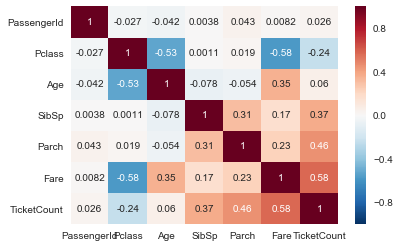

In [29]:
sns.heatmap(test.corr(), annot=True)

#### We see that Fare is highly correlated with Pclass and Ticket Count
    
    - we will aggregate the dataset on these columns and look at the mean and median fare for each group

In [30]:
test.groupby(['Pclass','TicketCount']).agg({'Fare': [np.mean,np.median]})

Fare           
                          mean     median
Pclass TicketCount                       
1      1             62.600818   42.45000
       2            104.985585   82.26670
       3            178.139600  178.13960
       4            211.500000  211.50000
       5            262.375000  262.37500
2      1             17.214430   13.00000
       2             32.638889   26.00000
       3             48.250000   48.25000
3      1              9.919933    7.85420
       2             20.676136   20.57500
       3             22.581250   22.58125
       4             69.550000   69.55000

#### Now we will look at the record which is missing Fare and determine what value we should assign it based on its values of Pclass and TicketCount

In [31]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,CabinLetter,TicketCount
152,1044,3,male,60.5,0,0,NaN,S,Mr,Missing,1


#### Because the records has a value of 3 for Pclass and 1 for TicketCount, we will assign it the mean value of this group which is approximately 10

In [32]:
test.fillna(10, inplace=True)

#### Double Check that no columns have any more missing values

In [33]:
print(test.info())
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null object
CabinLetter    418 non-null object
TicketCount    418 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 59.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
Title          889 non-null 

## Creating Dummy variables for Categorical Fields

    - Because many models require categorical variables to be in dummy form, we will create those dummy variables here and drop the original variables from the dataset

#### Using pandas get_dummies function. Add variable name as prefix and drop the first category in order to avoid having perfect collinearity between dummy variables for a given field

In [34]:
train_pclass = pd.get_dummies(train['Pclass'], prefix='Pclass', drop_first=True)
train_sex = pd.get_dummies(train['Sex'], prefix='Sex', drop_first=True)
train_embarked = pd.get_dummies(train['Embarked'], prefix='Embarked', drop_first=True)
train_title = pd.get_dummies(train['Title'], prefix='Title', drop_first=True)
train_cabinletter = pd.get_dummies(train['CabinLetter'], prefix='CabinLetter', drop_first=True)

In [35]:
test_pclass = pd.get_dummies(test['Pclass'], prefix='Pclass', drop_first=True)
test_sex = pd.get_dummies(test['Sex'], prefix='Sex', drop_first=True)
test_embarked = pd.get_dummies(test['Embarked'], prefix='Embarked', drop_first=True)
test_title = pd.get_dummies(test['Title'], prefix='Title', drop_first=True)
test_cabinletter = pd.get_dummies(test['CabinLetter'], prefix='CabinLetter', drop_first=True)

#### Concatenate the dummy variables with the original training dataset and drop the original categorical fields

In [36]:
train = pd.concat(
    [train,train_pclass,train_sex,train_embarked,train_title,train_cabinletter],
    axis=1).drop(['Pclass','Sex','Embarked','Title','CabinLetter'],axis=1)

In [37]:
test = pd.concat(
    [test,test_pclass,test_sex,test_embarked,test_title,test_cabinletter],
    axis=1).drop(['Pclass','Sex','Embarked','Title','CabinLetter'],axis=1)

## Double Check that the final train and test datasets have the correct fields

In [38]:
train.head(1)

,PassengerId,Survived,Age,SibSp,Parch,Fare,TicketCount,Pclass_2,Pclass_3,Sex_male,...,Title_Mrs,Title_Other,Title_Rev,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_Missing,CabinLetter_Other
0,1,0,22.0,1,0,7.25,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0


In [39]:
test.head(1)

,PassengerId,Age,SibSp,Parch,Fare,TicketCount,Pclass_2,Pclass_3,Sex_male,Embarked_Q,...,Title_Mrs,Title_Other,Title_Rev,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_Missing,CabinLetter_Other
0,892,34.5,0,0,7.8292,1,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0


## Export Cleaned Datasets as CSVs, dropping the index

In [40]:
train.to_csv('./train_cleaned.csv', index=False)
test.to_csv('./test_cleaned.csv', index=False)